## Copyright 2019 The TensorFlow Authors.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classify structured data with feature columns


# The Dataset

We will use a simplified version of the PetFinder [dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. We will use this information to predict the speed at which the pet will be adopted.

Following is a description of this dataset. Notice there are both numeric and categorical columns. There is a free text column which we will not use in this tutorial.

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer

## Import TensorFlow and other libraries

In [3]:
!pip install sklearn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Use Pandas to create a dataframe

[Pandas](https://pandas.pydata.org/) is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the dataset from a URL, and load it into a dataframe.

In [5]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [6]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## Create target variable

The task in the original dataset is to predict the speed at which a pet will be adopted (e.g., in the first week, the first month, the first three months, and so on). Let's simplify this for our tutorial. Here, we will transform this into a binary classification problem, and simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [7]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## Split the dataframe into train, validation, and test

The dataset we downloaded was a single CSV file. We will split this into train, validation, and test sets.

In [8]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


## Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [10]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [11]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['Age'])
    print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 0 30  2 72 10], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 0], shape=(5,), dtype=int64)


We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

## Demonstrate several types of feature columns
TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [12]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [13]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

### Numeric columns
The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A [numeric column](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [14]:
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[4.]
 [1.]
 [1.]
 [1.]
 [2.]]


In the PetFinder dataset, most columns from the dataframe are categorical.

### Bucketized columns
Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

In [15]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


### Categorical columns
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using [categorical_column_with_vocabulary_list](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), or loaded from a file using [categorical_column_with_vocabulary_file](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_file).

In [16]:
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


### Embedding columns
Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an [embedding column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Key point: using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [17]:
# Notice the input to the embedding column is the categorical column
# we previously created
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[-0.21583049 -0.48646516 -0.3153834   0.09122749  0.02320757  0.18311246
   0.20714295 -0.3532263 ]
 [-0.27950767 -0.6338011  -0.20905277 -0.18443114  0.4235029  -0.05360718
  -0.6102259  -0.38227928]
 [ 0.53691274 -0.19439492 -0.28775352  0.18469189  0.3030456   0.4482352
  -0.28087494  0.22280377]
 [-0.21583049 -0.48646516 -0.3153834   0.09122749  0.02320757  0.18311246
   0.20714295 -0.3532263 ]
 [ 0.15375333 -0.11788626 -0.3455216   0.2898492   0.37446553 -0.15077598
   0.13500915  0.5353396 ]]


### Hashed feature columns

Another way to represent a categorical column with a large number of values is to use a [categorical_column_with_hash_bucket](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket). This feature column calculates a hash value of the input, then selects one of the `hash_bucket_size` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

Key point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [18]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


### Crossed feature columns
Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that `crossed_column` does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a `hashed_column`, so you can choose how large the table is.

In [19]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

## Choose which columns to use


In [20]:
feature_columns = []

# numeric cols
for header in ['PhotoAmt', 'Fee', 'Age']:
    feature_columns.append(feature_column.numeric_column(header))

In [21]:
# bucketized cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

## Choose which columns to use


In [22]:
# indicator_columns
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
                          col_name, dataframe[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

## Choose which columns to use


In [23]:
# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [24]:
# crossed columns
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

### Create a feature layer
Now that we have defined our feature columns, we will use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to our Keras model.

In [25]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [26]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Create, compile, and train the model

## Create, compile, and train the model

In [27]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Create, compile, and train the model

In [28]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10


/Users/alicebizzarri/miniforge3/envs/asai/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


231/231 [==============================] - 3s 7ms/step - loss: 0.6972 - accuracy: 0.6564 - val_loss: 0.5424 - val_accuracy: 0.7378
Epoch 2/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5463 - accuracy: 0.7222 - val_loss: 0.5022 - val_accuracy: 0.7579
Epoch 3/10
231/231 [==============================] - 1s 4ms/step - loss: 0.5269 - accuracy: 0.7340 - val_loss: 0.4973 - val_accuracy: 0.7665
Epoch 4/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5155 - accuracy: 0.7435 - val_loss: 0.4826 - val_accuracy: 0.7719
Epoch 5/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5117 - accuracy: 0.7429 - val_loss: 0.4780 - val_accuracy: 0.7698
Epoch 6/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5052 - accuracy: 0.7478 - val_loss: 0.4894 - val_accuracy: 0.7654
Epoch 7/10
231/231 [==============================] - 2s 7ms/step - loss: 0.5026 - accuracy: 0.7548 - val_loss: 0.4783 - val_accuracy: 0.7774
Epoch 8/10
231/23

### Print the model

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_6 (DenseFeat  multiple                 1328      
 ures)                                                           
                                                                 
 dense (Dense)               multiple                  1510      
                                                                 
 dense_1 (Dense)             multiple                  11        
                                                                 
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________


### Plot history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


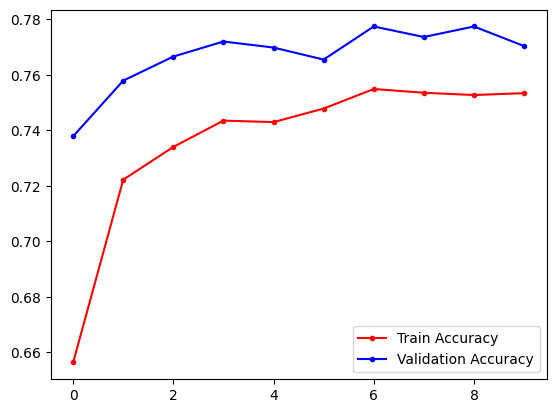

In [30]:
print(history.history.keys())
fig, ax = plt.subplots()
ax.plot(history.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
ax.legend()

## Evaluate and save the model 

We use the `.evaluate` function to evaluate the performance of the model

In [31]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)

73/73 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 0.7504
Accuracy 0.7504332661628723
Loss 0.5155341029167175


## Save Model

We can [save and load keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model`:

N.B. first, in colab we need mount drive.

In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
# model.save('drive/MyDrive/my_pet_classifier')
model.save('mymodel')
# test.to_csv('drive/MyDrive/test_data.csv')
test.to_csv('test_data.csv')

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


# Esercizio


## Esercizio
Ora tocca a voi.  Fate quanto segue nelle celle sottostanti:
- Costruire un modello variando numero di livelli e neuroni.
- Utilizzare la funzione di attivazione "relu" per gli strati nascosti e "sigmoid" per lo strato finale.
- Utilizzare un learning rate di .003.
- Graficare la traiettoria delle loss, l'accuratezza su i set di addestramento e di test.

Sperimentare con diversi tassi di apprendimento, numeri di epoche e strutture di rete.
Salvare su drive il modello.

In [34]:
def get_model_2(feature_columns):
    model = ... Crea il tuo modello ...
    return model

In [35]:
model_new = get_model_2(feature_columns)
opt = ...
model_new.compile(...)
hist2=model_new.fit(train_ds, batch_size=5, epochs=10, validation_data=val_ds)

Epoch 1/10


220/231 [===========================>..] - ETA: 0s - loss: 0.7319 - accuracy: 0.7091WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'Type': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=string>, 'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Breed1': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'Gender': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=string>, 'Color1': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'Color2': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'MaturitySize': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'FurLength': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'Vaccinated': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=string>, 'Sterilized': <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=string>, 'Health': <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=string>, 'Fee': <tf.Tensor 'Iterato

231/231 [==============================] - 3s 8ms/step - loss: 0.7282 - accuracy: 0.7087 - val_loss: 0.5199 - val_accuracy: 0.7519
Epoch 2/10
231/231 [==============================] - 2s 6ms/step - loss: 0.6218 - accuracy: 0.7287 - val_loss: 0.4969 - val_accuracy: 0.7692
Epoch 3/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5735 - accuracy: 0.7360 - val_loss: 0.4847 - val_accuracy: 0.7589
Epoch 4/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5409 - accuracy: 0.7416 - val_loss: 0.4726 - val_accuracy: 0.7741
Epoch 5/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5188 - accuracy: 0.7505 - val_loss: 0.4832 - val_accuracy: 0.7665
Epoch 6/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5150 - accuracy: 0.7500 - val_loss: 0.4806 - val_accuracy: 0.7654
Epoch 7/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5022 - accuracy: 0.7512 - val_loss: 0.4990 - val_accuracy: 0.7476
Epoch 8/10
231/23

## Plot result

/var/folders/5b/qdxrh_011gvbggg89qvhpwbw0000gn/T/ipykernel_71554/2866296971.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/5b/qdxrh_011gvbggg89qvhpwbw0000gn/T/ipykernel_71554/2866296971.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


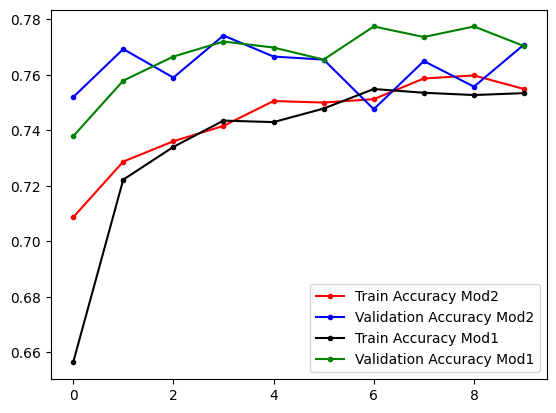

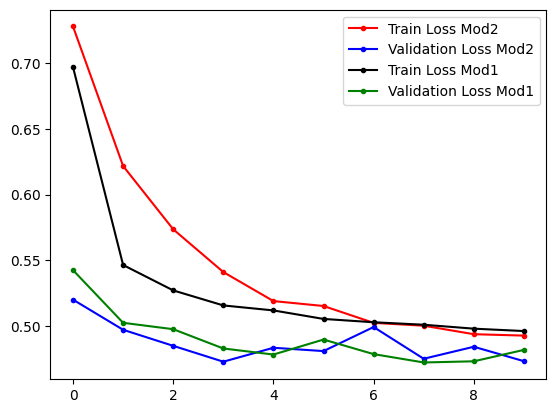

In [36]:
fig, ax = plt.subplots()
...
fig, ax = plt.subplots()
...
fig.show()

In [37]:
loss2, acc2 = ...

231/231 [==============================] - 1s 3ms/step - loss: 0.4784 - accuracy: 0.7659
0.4783969521522522 0.7659487724304199
0.5155341029167175 0.7504332661628723
